# [**Workflows for atomistic simulations**](http://potentials.rub.de/) 

## **Day 1 - Atomistic simulations with [pyiron](https://pyiron.org)**


### **Exercise 1: Introduction to atomistic simulations with pyiron**

Before the excercise, you should:

* Be familiar with python especially with numerical libraries like numpy and plotting tools like matplotlib
* Understand how Jupyter Notebooks work

The aim of this exercise is to make you familiar with:

* A general overview of what pyiron can do
* How to set up atomic structures and run atomistic simulation codes through pyiron

### **Importing necessary libraries**

As a first step we import the libraries [numpy](http://www.numpy.org/) for data analysis and [matplotlib](https://matplotlib.org/) for visualization.

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

Fundamentally, we only need to import one module from `pyiron`: the `Project` class

In [3]:
from pyiron import Project

The Project object introduced below is central in pyiron. It allows to name the project as well as to derive all other objects such as structures, jobs etc. without having to import them. Thus, by code completion *Tab* the respective commands can be found easily.

We now create a pyiron Project named 'first_steps'.

### **Creation of a project instance**

In [8]:
pr = Project("first_steps")

The project name also applies for the directory that is created for the project. All data generated by this `Project` object resides in this directory.

In [9]:
pr.path

'/cmmc/u/zora/pyiron/projects/2022/POTENTIALS/TutorialNotebooks/introduction/first_steps/'

In [10]:
pr

{'groups': [], 'nodes': []}

The `groups` and `nodes` will be populated later, as we add jobs and sub project to it.

### **Creating atomic structures**

Every atomistic simulation needs an atomic structure. For more details on generating and manipulating structures, please have a look at our [structures example](https://pyiron.readthedocs.io/en/latest/source/notebooks/structures.html). In this section however, we show how to generate and manipulate bulk crystals, surfaces, etc. pyiron's structure class is derived from the popular [`ase` package](https://wiki.fysik.dtu.dk/ase/ase/build/build.html) and any `ase` function to manipulate structures can also be applied here.

Creating a bulk fcc cubic unitcell

In [11]:
Al_unitcell_cubic = pr.create.structure.bulk('Al', cubic=True, a=4.04)
Al_unitcell_cubic

Al: [0. 0. 0.]
Al: [0.   2.02 2.02]
Al: [2.02 0.   2.02]
Al: [2.02 2.02 0.  ]
pbc: [ True  True  True]
cell: 
Cell([4.04, 4.04, 4.04])

Creating a super cell.

In [12]:
Al_supercell_3_3_3 = Al_unitcell_cubic.repeat([3, 3, 3])
Al_supercell_3_3_3.plot3d(particle_size=2)

NGLWidget()

Creating a bulk fcc primitive unitcell and supercell.

In [13]:
Al_unitcell_primitive = pr.create.structure.bulk('Al', a=4.04)
Al_unitcell_primitive.repeat([3, 3, 3]).plot3d(particle_size=2)

NGLWidget()

Creating a vacancy is easy, just delete an atom.

In [14]:
Al_vacancy = Al_supercell_3_3_3.copy()
del Al_vacancy[0] # Deleting the first atom
print(Al_supercell_3_3_3.get_chemical_formula(), Al_vacancy.get_chemical_formula())
Al_vacancy.plot3d(particle_size=2)

Al108 Al107


NGLWidget()

Surfaces are also easy to create, thanks to ASE integration.

In [19]:
num_layers = 4
Al_fcc_111 = pr.create.structure.surface("Al", surface_type="fcc111", size=(4,4,num_layers), vacuum=12, orthogonal=True)
Al_fcc_111.plot3d(particle_size=2)

NGLWidget()

If needed you can also have full control over the structure.  Here we'll use it to setup a single atom and a dimer.

In [20]:
cell = np.eye(3) * 10
Al_atom_box = pr.create.structure.atoms("Al", cell=cell, scaled_positions=[[0.5, 0.5, 0.5]])
Al_atom_box.plot3d(particle_size=2)

NGLWidget()

In [21]:
cell = np.eye(3) * 10
Al_atom_1 = pr.create.structure.atoms("Al", cell=cell, scaled_positions=[[0.5, 0.5, 0.5]])
Al_atom_2 = Al_atom_1.copy()

dimer_length = 2.5
Al_atom_2.positions[:, 2] += dimer_length
Al_dimer = Al_atom_1 + Al_atom_2
Al_dimer.center()
Al_dimer.plot3d()

NGLWidget()

### **Running an atomistic calculation using interatomic potentials (with LAMMPS)**

Once we have an atomic structure, we can set up a simulation "job" of any atomistic simulation that is intergrated within pyiron. In this section, we are going to use the popular [LAMMPS code](https://lammps.sandia.gov/).

In [23]:
# Create a job
job_lammps = pr.create.job.Lammps(job_name="lammps_job")

Every atomistic simulation code needs an input atomic structure. We use the Al supercell structure we created earlier

In [24]:
# Assign an atomic structure to the job
job_lammps.structure = Al_supercell_3_3_3

Once the structure is assigned, an appropriate potential should also be chosen. This list of available for the structure containing Al can be found below.  This list originates from the NIST Interatomic Potential Database.

In [28]:
# See available potentials
job_lammps.list_potentials()[20:30]

['2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1',
 '2007--Silva-A-C--Al-Ni--LAMMPS--ipr1',
 '2008--Mendelev-M-I--Al--LAMMPS--ipr1',
 '2009--Kim-Y-M--Mg-Al--LAMMPS--ipr1',
 '2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1',
 '2009--Purja-Pun-G-P--Ni-Al--LAMMPS--ipr1',
 '2009--Zhakhovskii-V-V--Al--LAMMPS--ipr2',
 '2010--Lee-E--Fe-Al--LAMMPS--ipr1',
 '2010--Mendelev-M-I--fictional-Al-1--LAMMPS--ipr1',
 '2010--Mendelev-M-I--fictional-Al-2--LAMMPS--ipr1']

In [29]:
# Choose one of these potentials
job_lammps.potential = "2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1"

At this stage, the computational parameters for the simulation needs to be specified. pyiron parses generic computational parameters into code specific parameters allowing for an easy transition between simulation codes

In [30]:
# specify calculation details: in this case: MD at 800 K in the NPT ensemble (pressure=0) for 10000 steps
job_lammps.calc_md(temperature=800, pressure=0, n_ionic_steps=10000)

We can now see how pyiron sets-up the corresponding LAMMPS input

In [31]:
job_lammps.input.control

,Parameter,Value,Comment
0,units,metal,
1,dimension,3,
2,boundary,p p p,
3,atom_style,atomic,
4,read_data,structure.inp,
5,include,potential.inp,
6,fix___ensemble,all npt temp 800.0 800.0 0.1 iso 0.0 0.0 1.0,
7,variable___dumptime,equal 100,
8,variable___thermotime,equal 100,
9,timestep,0.001,


Once the `run()` commmand is called, pyiron creates necessary input files, calls the simulation code, and finally parses and stores the output.

In [32]:
job_lammps.run()

The job lammps_job was saved and received the ID: 17157590


When printing the project, the saved job will also appear under `nodes` now.

In [33]:
pr

{'groups': [], 'nodes': ['lammps_job']}

In [34]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,17157590,finished,Al108,lammps_job,/lammps_job,/cmmc/u/,zora/pyiron/projects/2022/POTENTIALS/TutorialNotebooks/introduction/first_steps/,2022-05-26 17:17:18.119373,2022-05-26 17:17:22.505009,4.0,zora@cmti001#1,Lammps,0.1,None,None


## **Analysing a calculation**

In [35]:
# Load the job
job_loaded = pr['lammps_job']

Jobs in turn also have groups and nodes in them, corresponding to the input and output that was stored for them.

In [36]:
job_loaded

{'groups': ['input', 'output'], 'nodes': ['HDF_VERSION', 'NAME', 'TYPE', 'VERSION', 'server', 'status']}

You will generally find all relevant data in the `output` group, for your further processing.

In [37]:
job_loaded["output"]

{'groups': ['generic', 'structure'], 'nodes': []}

The group `structure` holds the final structure at the end of the simulation, whereas the `generic` group keeps output you can expect for all atomistic jobs in pyiron.

In [38]:
job_loaded["output/generic"]

{'groups': [], 'nodes': ['cells', 'energy_pot', 'energy_tot', 'forces', 'indices', 'positions', 'pressures', 'steps', 'temperature', 'unwrapped_positions', 'velocities', 'volume']}

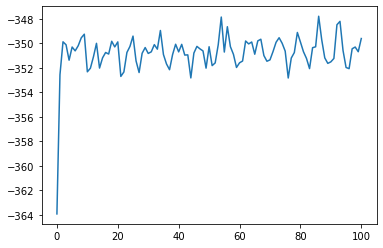

In [40]:
plt.plot(job_loaded["output/generic/energy_pot"])

Structures from the MD trajectory can be accessed using `get_structure`, passing as the argument the index of the step you want to retrieve.

In [43]:
final_struct = job_loaded.get_structure(frame=5)
final_struct.plot3d()

NGLWidget()

Using the `plot3d` method you can visualize the structure interactively.  To see the full trajectory, you can use the `animate_structure` method.

In [44]:
job_loaded.animate_structure()

NGLWidget(max_frame=100)

Let's go through a few more examples of visualizing the output of the job.

When you run the job, you can specify how often pyiron and lammps should be writing the intermediate structures and energies, etc. The default for this is every 100 steps.  The output group `generic/steps` contains an array to which actual step of the MD trajectory a snapshot belongs.

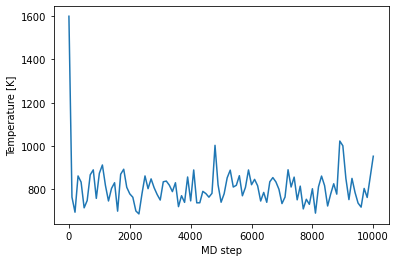

In [27]:
temperatures = job_loaded['output/generic/temperature']
steps = job_loaded['output/generic/steps']
plt.plot(steps, temperatures)
plt.xlabel('MD step')
plt.ylabel('Temperature [K]');

We can also make a histogram of the positions during the simulation.

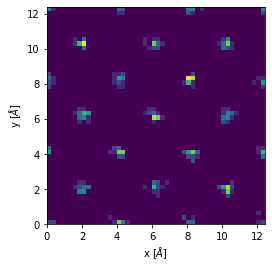

In [46]:
pos = job_loaded['output/generic/positions']
# The first axis refers to the simulation step, the second to the atom in the structure.
x = pos[:, :, 0]
y = pos[:, :, 1]
z = pos[:, :, 2]
# Let's pick only the bottom layer of atoms
sel = np.abs(z) < 0.1
plt.hist2d(x[sel], y[sel], bins=50)
plt.xlabel('x [$\AA$]')
plt.ylabel('y [$\AA$]')
plt.gca().set_aspect('equal', 'box');

### **Running an atomistic calculation using DFT (with SPHInX)**

In [70]:
job_sphinx = pr.create.job.Sphinx("sphinx_job")
job_sphinx.structure = Al_unitcell_primitive
job_sphinx.set_exchange_correlation_functional("PBE")
job_sphinx.plane_wave_cutoff = 350
job_sphinx.calc_static()
job_sphinx.set_occupancy_smearing("fermi", width=0.2)
job_sphinx.run()

The job sphinx_job was saved and received the ID: 17157612


In [71]:
job_sphinx["output/generic"]

DataContainer({'dft': DataContainer({'n_valence': {'Al': 3}, 'bands_k_weights': array([0.03125, 0.09375, 0.09375, 0.09375, 0.09375, 0.1875 , 0.1875 ,
       0.09375, 0.03125, 0.09375]), 'kpoints_cartesian': array([[ 0.15999579,  0.15999579,  0.15999579],
       [-0.15999579, -0.15999579,  1.11997052],
       [-0.47998736, -0.47998736,  2.07994525],
       [-0.79997894, -0.79997894,  3.03991998],
       [-0.47998736,  0.79997894,  0.79997894],
       [-0.79997894,  0.47998736,  1.75995367],
       [-1.11997052,  0.15999579,  2.7199284 ],
       [-1.11997052,  1.43996209,  1.43996209],
       [ 0.47998736,  0.47998736,  0.47998736],
       [ 0.15999579,  0.15999579,  1.43996209]]), 'bands_e_fermi': array([5.098309, 5.078148]), 'bands_occ': array([[[2.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [2.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [2.    , 2.    , 0.    , 0.    , 0.    , 0.    ],
        [2.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [2.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [2.    , 2.    , 0.    , 0.    , 0.    , 0.    ],
        [2.    , 1.0349, 0.    , 0.    , 0.    , 0.    ],
        [2.    , 0.0699, 0.    , 0.    , 0.    , 0.    ],
        [2.    , 2.    , 0.    , 0.    , 0.    , 0.    ],
        [2.    , 2.    , 0.    , 0.    , 0.    , 0.    ]]]), 'bands_eigen_values': array([[[ 5.7789, 13.2641, 16.6274, 16.6275, 19.6991, 20.6136],
        [ 3.5357,  7.1765, 11.5595, 16.7236, 18.6749, 18.6808],
        [ 0.2388,  1.9374, 12.5406, 13.8199, 15.5973, 19.6863],
        [ 4.6529, 10.2461, 13.7961, 15.313 , 16.5609, 19.1035],
        [ 2.4286,  8.1645, 10.5286, 11.8656, 13.337 , 17.3788],
        [ 1.8737,  4.0083,  6.3981,  8.5688, 16.7898, 20.9819],
        [ 1.3288,  5.074 ,  9.5226, 11.5907, 17.7268, 19.8268],
        [ 0.8065,  5.3119,  7.1531, 10.9005, 12.2692, 16.4384],
        [ 2.427 ,  4.0713, 15.7673, 15.7673, 17.7195, 17.7196],
        [ 0.8409,  2.9605,  7.4753, 12.847 , 14.677 , 22.6242]]]), 'scf_convergence': [True], 'scf_energy_int': [[-57.24888770726021, -57.23777761192162, -57.237504800359225, -57.237503922220576]], 'scf_energy_free': [[-57.25710891829522, -57.24600642940985, -57.24573252071158, -57.24573158080308]], 'scf_magnetic_forces': [], 'scf_computation_time': [[0.084533, 0.167125, 0.251423, 0.332953]], 'scf_energy_zero': [[-57.255053615543275, -57.2439492250446, -57.243675590637096, -57.24367466615746]], 'scf_energy_band': [[1.6287129549739296, 1.5900136190459833, 1.5911892940637016, 1.5905994626133038]], 'scf_electronic_entropy': [[1.1185526120868474, 1.119587522358613, 1.1194382488842947, 1.11942984538236]], 'scf_residue': [[0.00437191, 0.00023619, 1.93516e-05, 1.90379e-06]], 'energy_int': array([-57.23750392]), 'energy_free': array([-57.24573158]), 'magnetic_forces': array([], dtype=float64), 'computation_time': array([0.332953]), 'energy_zero': array([-57.24367467]), 'energy_band': array([1.59059946]), 'electronic_entropy': array([1.11942985]), 'residue': array([1.90379e-06])}), 'positions': array([[[0., 0., 0.]]]), 'cells': array([[[0.  , 2.02, 2.02],
        [2.02, 0.  , 2.02],
        [2.02, 2.02, 0.  ]]]), 'volume': array([16.48480823]), 'forces': array([[[ 0., -0.,  0.]]]), 'energy_tot': array([-57.24573158]), 'energy_pot': array([-57.24573158])})

In [72]:
job_sphinx["output/generic/energy_tot"] # Energy for every ionic step

array([-57.24573158])

In [73]:
job_sphinx['output/electronic_structure']

ElectronicStructure Instance
----------------------------
Number of spin channels: 1
Number of k-points: 10
Number of bands: 6
spin 0: Is a metal: True

In [74]:
job_sphinx.input

Group({'sphinx': Group({'pawPot': Group({'species': Group([Group({'name': '"Al"', 'potType': '"VASP"', 'element': '"Al"', 'potential': '"Al_POTCAR"'})])}), 'structure': Group({'cell': array([[0.        , 3.81724677, 3.81724677],
       [3.81724677, 0.        , 3.81724677],
       [3.81724677, 3.81724677, 0.        ]]), 'species': Group([Group({'element': '"Al"', 'atom': Group([Group({'coords': array([0., 0., 0.])})])})])}), 'basis': Group({'eCut': 25.724525522958494, 'kPoint': Group({'coords': array([0.5, 0.5, 0.5]), 'weight': 1, 'relative': True}), 'folding': array([4, 4, 4]), 'saveMemory': True}), 'PAWHamiltonian': Group({'nEmptyStates': 4, 'ekt': 0.2, 'MethfesselPaxton': 1, 'xc': 'PBE', 'spinPolarized': False}), 'initialGuess': Group({'waves': Group({'lcao': Group([]), 'pawBasis': True}), 'rho': Group({'atomicOrbitals': True}), 'noWavesStorage': False}), 'main': Group({'scfDiag': Group([Group({'rhoMixing': '1.0', 'spinMixing': '1.0', 'dEnergy': 3.674932217565499e-06, 'maxSteps': '100', 'preconditioner': Group({'type': 'KERKER', 'scaling': 1.0, 'spinScaling': 1.0}), 'blockCCG': Group([])})]), 'evalForces': Group({'file': '"relaxHist.sx"'})})}), 'EnCut': 350, 'KpointCoords': [0.5, 0.5, 0.5], 'KpointFolding': [4, 4, 4], 'EmptyStates': 4, 'Sigma': 0.2, 'Xcorr': 'PBE', 'VaspPot': True, 'Estep': 100, 'Ediff': 0.0001, 'WriteWaves': True, 'KJxc': False, 'SaveMemory': True, 'rhoMixing': 1.0, 'spinMixing': 1.0, 'rhoResidualScaling': 1.0, 'spinResidualScaling': 1.0, 'CheckOverlap': True, 'THREADS': 1, 'use_on_the_fly_cg_optimization': True, 'FermiDirac': 1})

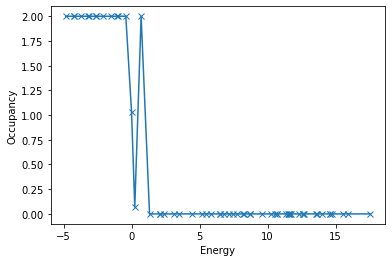

In [75]:
eigenvalues = job_sphinx['output/electronic_structure/eig_matrix'].flatten()
occupancies = job_sphinx['output/electronic_structure/occ_matrix'].flatten()

efermi = job_sphinx['output/electronic_structure/efermi']
args = np.argsort(eigenvalues)
# args = np.argsort(eigenvalues)
plt.plot(eigenvalues[args] - efermi, occupancies[args], "-x")
plt.xlabel('Energy')
plt.ylabel('Occupancy');

## **Task 1: Energy volume curve for Al**

First we create some functions to extract the final energy and volume of a job

In [83]:
def get_volume(job):
    return job["output/generic/volume"][-1]

In [84]:
def get_energy(job):
    return job["output/generic/energy_tot"][-1]

In [85]:
job_loaded = pr['lammps_job']

In [86]:
get_energy(job_loaded), get_volume(job_loaded)

(-337.099564313231, 1929.39754690265)

We create first a few jobs with different lattice parameters.

In [89]:
pr_ev = pr.create_group("E_V_curve") # Creating a new sub-project within the main project
a_list = np.linspace(3.8, 4.4, 7)
for a in a_list:
    job_name = "job_a_{:.4}".format(a).replace(".", "_")
    job = pr_ev.create.job.Lammps(job_name)
    job.structure = pr_ev.create.structure.bulk("Al", a=a)
    job.potential = "2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1"
    job.calc_minimize()
    job.run()

The job job_a_3_8 was saved and received the ID: 17157622
The job job_a_3_9 was saved and received the ID: 17157623
The job job_a_4_0 was saved and received the ID: 17157624
The job job_a_4_1 was saved and received the ID: 17157625
The job job_a_4_2 was saved and received the ID: 17157626
The job job_a_4_3 was saved and received the ID: 17157627
The job job_a_4_4 was saved and received the ID: 17157628


In [90]:
pr

{'groups': ['E_V_curve'], 'nodes': ['lammps_job', 'sphinx_job']}

In [91]:
pr_ev.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
2,17157622,finished,Al,job_a_3_8,/job_a_3_8,/cmmc/u/,zora/pyiron/projects/2022/POTENTIALS/TutorialNotebooks/introduction/first_steps/E_V_curve/,2022-05-26 18:17:31.140377,2022-05-26 18:17:31.748393,0.0,zora@cmti001#1,Lammps,0.1,None,None
3,17157623,finished,Al,job_a_3_9,/job_a_3_9,/cmmc/u/,zora/pyiron/projects/2022/POTENTIALS/TutorialNotebooks/introduction/first_steps/E_V_curve/,2022-05-26 18:17:32.454690,2022-05-26 18:17:33.067092,0.0,zora@cmti001#1,Lammps,0.1,None,None
4,17157624,finished,Al,job_a_4_0,/job_a_4_0,/cmmc/u/,zora/pyiron/projects/2022/POTENTIALS/TutorialNotebooks/introduction/first_steps/E_V_curve/,2022-05-26 18:17:33.779925,2022-05-26 18:17:34.411568,0.0,zora@cmti001#1,Lammps,0.1,None,None
5,17157625,finished,Al,job_a_4_1,/job_a_4_1,/cmmc/u/,zora/pyiron/projects/2022/POTENTIALS/TutorialNotebooks/introduction/first_steps/E_V_curve/,2022-05-26 18:17:35.117607,2022-05-26 18:17:35.712968,0.0,zora@cmti001#1,Lammps,0.1,None,None
6,17157626,finished,Al,job_a_4_2,/job_a_4_2,/cmmc/u/,zora/pyiron/projects/2022/POTENTIALS/TutorialNotebooks/introduction/first_steps/E_V_curve/,2022-05-26 18:17:36.413559,2022-05-26 18:17:37.021632,0.0,zora@cmti001#1,Lammps,0.1,None,None
0,17157627,finished,Al,job_a_4_3,/job_a_4_3,/cmmc/u/,zora/pyiron/projects/2022/POTENTIALS/TutorialNotebooks/introduction/first_steps/E_V_curve/,2022-05-26 18:17:37.723543,2022-05-26 18:17:38.330038,0.0,zora@cmti001#1,Lammps,0.1,None,None
1,17157628,finished,Al,job_a_4_4,/job_a_4_4,/cmmc/u/,zora/pyiron/projects/2022/POTENTIALS/TutorialNotebooks/introduction/first_steps/E_V_curve/,2022-05-26 18:17:39.027896,2022-05-26 18:17:39.638075,0.0,zora@cmti001#1,Lammps,0.1,None,None


Now that we have all the jobs and they finished correctly, we can analyze them.

  0%|          | 0/7 [00:00<?, ?it/s]

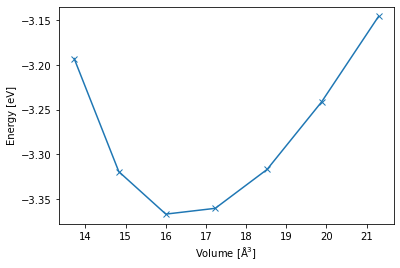

In [92]:
vol_list = list()
energy_list = list()

for job in pr["E_V_curve"].iter_jobs(status="finished"):
    vol_list.append(get_volume(job))
    energy_list.append(get_energy(job))

args = np.argsort(vol_list)
vol_list = np.array(vol_list)
energy_list = np.array(energy_list)
plt.plot(vol_list[args], energy_list[args], "-x")
plt.xlabel("Volume [$\mathrm{\AA^3}$]")
plt.ylabel("Energy [eV]");

## Avoid loading the full job where possible to speed things up!

  0%|          | 0/7 [00:00<?, ?it/s]

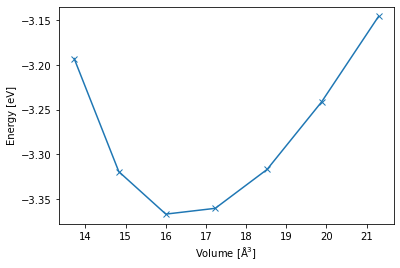

In [100]:
vol_list = list()
energy_list = list()

for job in pr["E_V_curve"].iter_jobs(convert_to_object=False, status="finished"):
    vol_list.append(get_volume(job))
    energy_list.append(get_energy(job))

args = np.argsort(vol_list)
vol_list = np.array(vol_list)
energy_list = np.array(energy_list)
plt.plot(vol_list[args], energy_list[args], "-x")
plt.xlabel("Volume [$\mathrm{\AA^3}$]")
plt.ylabel("Energy [eV]");

## **Task 2: E-V curves for DFT**

We now do the same with a DFT job to allow us to compare.  Notice that the structure of the code is almost the same between DFT and Lammps, just the input parameters are different.

In [94]:
pr_ev = pr.create_group("E_V_curve_DFT") # Creating a new sub-project within the main project
a_list = np.linspace(3.8, 4.4, 7)
for a in a_list:
    job_name = "job_a_{:.4}".format(a).replace(".", "_")
    job = pr_ev.create.job.Sphinx(job_name)
    job.structure = pr_ev.create.structure.bulk("Al", a=a)
    job.set_exchange_correlation_functional("PBE")
    job.plane_wave_cutoff = 350
    job.set_kpoints(mesh=[4, 4, 4])
    job.set_occupancy_smearing("fermi", 0.1)
    job.calc_minimize()
    job.run()

The job job_a_3_8 was saved and received the ID: 17157629
The job job_a_3_9 was saved and received the ID: 17157630
The job job_a_4_0 was saved and received the ID: 17157631
The job job_a_4_1 was saved and received the ID: 17157632
The job job_a_4_2 was saved and received the ID: 17157633
The job job_a_4_3 was saved and received the ID: 17157634
The job job_a_4_4 was saved and received the ID: 17157635


In [101]:
def get_volume(job):
    if job['NAME'] == 'Sphinx':
        return job["output/generic"].to_object(lazy=True).volume[-1]
    else:
        return job["output/generic/volume"][-1]

In [102]:
def get_energy(job):
    if job['NAME'] == 'Sphinx':
        return job["output/generic"].to_object(lazy=True).energy_tot[-1]
    else:
        return job["output/generic/energy_tot"][-1]

Also for the analysis the code necessary is the same, allowing us to easily loop over both groups and plot them together.

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

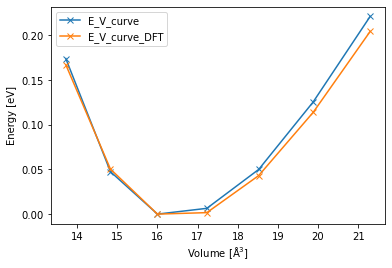

In [97]:
for group in pr.iter_groups():
    vol_list = list()
    energy_list = list()
    for job in group.iter_jobs(convert_to_object=False, status="finished"):
        vol_list.append(get_volume(job))
        energy_list.append(get_energy(job))
    args = np.argsort(vol_list)
    vol_list = np.array(vol_list)
    energy_list = np.array(energy_list)
    plt.plot(vol_list[args], energy_list[args] - np.min(energy_list), "-x", label=group.name)
plt.xlabel("Volume [$\mathrm{\AA^3}$]")
plt.ylabel("Energy [eV]")
plt.legend();

## **Advanced pyiron: Automated workflows and analysis tools**

While we could in principle obtain thee E-V cureves by setting up and analyzing the calculations manually as done above, we could also use predefined workflows in pyiron which does this automatically

In [103]:
num_pot = 3
pot_finder = pr.inspect_emperical_potentials()
pot_list = pot_finder.find("Al").Name.to_list()[20:20+num_pot]
pot_list

['2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1',
 '2007--Silva-A-C--Al-Ni--LAMMPS--ipr1',
 '2008--Mendelev-M-I--Al--LAMMPS--ipr1']

In [104]:
def clean_project_name(name):
    return name.replace("-", "_")

In [105]:
# Automated Murnaghan using pyiron tables

pr_murn = Project("murn_auto") 

for pot in pot_list:
    
    lammps_job = pr_murn.create.job.Lammps("lammps_ref")
    lammps_job.structure = pr.create.structure.bulk("Al")
    lammps_job.potential = pot
    lammps_job.calc_minimize()
    
    # Creating a Murnaghan workflow (char names not to exceed 50 chars)
    job_name = "murn_ref_{}".format(clean_project_name(pot))[:40]
    
    # The job type 'Murnaghan' sets up the appropriate workflow 
    murn_job = lammps_job.create_job(pr.job_type.Murnaghan, job_name)
    murn_job.input["num_points"] = 9
    murn_job.run()

2022-05-26 18:37:06,272 - pyiron_log - WARNING - The job murn_ref_2005__Mendelev_M_I__Al_Fe__LAMM is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-05-26 18:37:06,674 - pyiron_log - WARNING - The job murn_ref_2007__Silva_A_C__Al_Ni__LAMMPS_ is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-05-26 18:37:07,078 - pyiron_log - WARNING - The job murn_ref_2008__Mendelev_M_I__Al__LAMMPS_ is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


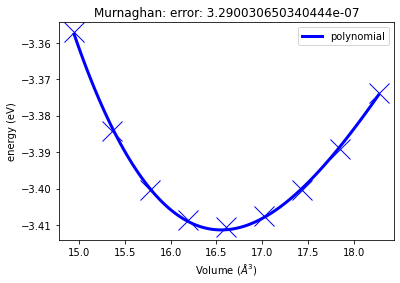

<AxesSubplot:title={'center':'Murnaghan: error: 3.290030650340444e-07'}, xlabel='Volume ($\\AA^3$)', ylabel='energy (eV)'>

In [106]:
murn_job.plot()

In [107]:
murn_job["output/equilibrium_volume"], murn_job["output/equilibrium_bulk_modulus"]

(16.55126935477302, 89.3059374981996)

In [108]:
np.linalg.norm(murn_job["output/structure/cell/cell"][0]) * np.sqrt(2)

4.045421385072271

We now analyze the data using our in-built pyiron tables class

In [109]:
# A filter function that selects only Murnaghan jobs
def get_only_murn(job_table):
    return (job_table.hamilton == "Murnaghan") & (job_table.status == "finished")

# Functions to obtain output from Murnaghan jobs
def get_eq_vol(job_path):
    return job_path["output/equilibrium_volume"]

def get_eq_lp(job_path):
    return np.linalg.norm(job_path["output/structure/cell/cell"][0]) * np.sqrt(2)

def get_eq_bm(job_path):
    return job_path["output/equilibrium_bulk_modulus"]

def get_potential(job_path):
    return job_path["lammps_ref/input/potential/Name"]

In [110]:
# Creating a pyiron table and processing output
table = pr_murn.create.table("table_murn", delete_existing_job=True)
table.db_filter_function = get_only_murn
table.add["potential"] = get_potential
table.add["a"] = get_eq_lp
table.add["eq_vol"] = get_eq_vol
table.add["eq_bm"] = get_eq_bm

table.run()
table.get_dataframe()

The job table_murn was saved and received the ID: 17157647


Loading and filtering jobs:   0%|          | 0/6 [00:00<?, ?it/s]

Processing jobs:   0%|          | 0/6 [00:00<?, ?it/s]

,job_id,potential,a,eq_vol,eq_bm
0,17073551,2008--Mendelev-M-I--Cu--LAMMPS--ipr1,3.610000,11.998747,165.207731
1,17073561,2009--Bonny-G--Fe-Cu-Ni--LAMMPS--ipr1,3.610000,11.804998,144.547023
2,17073571,2009--Kang-K-H--Cu-Ag--LAMMPS--ipr1,3.610000,11.792334,146.245735
3,17073648,2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1,4.050000,16.419614,85.214270
4,17073658,2007--Silva-A-C--Al-Ni--LAMMPS--ipr1,4.050000,16.542723,81.444776
5,17073668,2008--Mendelev-M-I--Al--LAMMPS--ipr1,4.045421,16.551269,89.305937
